# MedGemma 3 - 4B - Evaluation

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt

sys.path.append(r"C:\Users\janbe\Documents\GitHub Repos\pulse")
from src.eval.llm_analyzer import LLMAnalyzer
from src.eval.pulse_score import PULSEScoreCalculator

In [3]:
model_id = "medgemma"
base_output_dir = (
    r"C:\Users\janbe\Documents\GitHub Repos\pulse\output_to_keep\results_benchmark"
)
model_output_dir = os.path.join(base_output_dir, "llms", model_id)
results_output_dir = os.path.join(base_output_dir, r"results_output")


prompt_approaches = os.listdir(model_output_dir)
print(prompt_approaches)

# Try to load results_dict from json before calculating
results_loaded = False
results_output_jsons = os.path.join(results_output_dir, "jsons")
results_json_path = f"{model_id}_results.json"

if not results_loaded:
    best_prompt_approach = None

    results_dict = {}

    for prompt_approach in prompt_approaches:

        if not os.path.isdir(os.path.join(model_output_dir, prompt_approach)):
            continue

        print("=" * 50)

        print(f"\nPrompting Approach {prompt_approach}")

        cat_files = LLMAnalyzer.categorize_files(
            [os.path.join(model_output_dir, prompt_approach)],
            verbose=False,
        )

        df_mdata = LLMAnalyzer.load_metadata(cat_files["metadata_files"], verbose=True)

        # Filter for final prediction step if agent is used

        if "Step Name" in df_mdata.columns:

            df_mdata = df_mdata[
                df_mdata["Step Name"] == "final_prediction"
            ].reset_index(drop=True)

        ps = PULSEScoreCalculator()

        pulse_score = ps.calculate_pulse_score_from_raw_data(
            df=df_mdata,
        )
        pulse_score["model_id"] = model_id
        pulse_score["prompting_id"] = prompt_approach

        pulse_score_temp = pulse_score["overall"]["overall_score"]

        results_dict[prompt_approach] = pulse_score

        if best_prompt_approach is None or pulse_score_temp > best_prompt_approach[1]:

            best_prompt_approach = (prompt_approach, pulse_score_temp)

    print(
        f"\nBest prompt approach: {best_prompt_approach[0]} with PULSE score: {best_prompt_approach[1]}"
    )

    # Save results as json. Uses pulse-result format
    json_output_path = os.path.join(results_output_jsons, f"{model_id}_results.json")
    LLMAnalyzer.save_results_dict_as_json(
        results_dict, model_output_dir, json_output_path
    )

['liu_2023_few_shot_preprocessor', 'sarvari_2024_aggregation_preprocessor', 'zhu_2024a_cot_preprocessor', 'zhu_2024b_one_shot_preprocessor', 'zhu_2024b_zero_shot_preprocessor']

Prompting Approach liu_2023_few_shot_preprocessor
Model Name: Gemma3, Task: aki, Dataset: eicu, Timestamp: 20250701_095810
Model Name: Gemma3, Task: aki, Dataset: hirid, Timestamp: 20250701_095810
Model Name: Gemma3, Task: aki, Dataset: miiv, Timestamp: 20250701_095810
Model Name: Gemma3, Task: mortality, Dataset: eicu, Timestamp: 20250701_095810
Model Name: Gemma3, Task: mortality, Dataset: hirid, Timestamp: 20250701_095810
Model Name: Gemma3, Task: mortality, Dataset: miiv, Timestamp: 20250701_095810
Model Name: Gemma3, Task: sepsis, Dataset: eicu, Timestamp: 20250701_095810
Model Name: Gemma3, Task: sepsis, Dataset: hirid, Timestamp: 20250701_095810
Model Name: Gemma3, Task: sepsis, Dataset: miiv, Timestamp: 20250701_095810
Preparing data for Gemma3 PULSE score calculation...
Model Type: LLM

⚠️ Wrongly labl

## Model Metrics

In [4]:
df_results = LLMAnalyzer.load_metrics_from_prompt_approaches(base_output_dir, prompt_approaches)

C:\Users\janbe\Documents\GitHub Repos\pulse\src\eval\llm_analyzer.py:865: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_df = plot_df.groupby(["Group", "Metric"], as_index=False).agg(


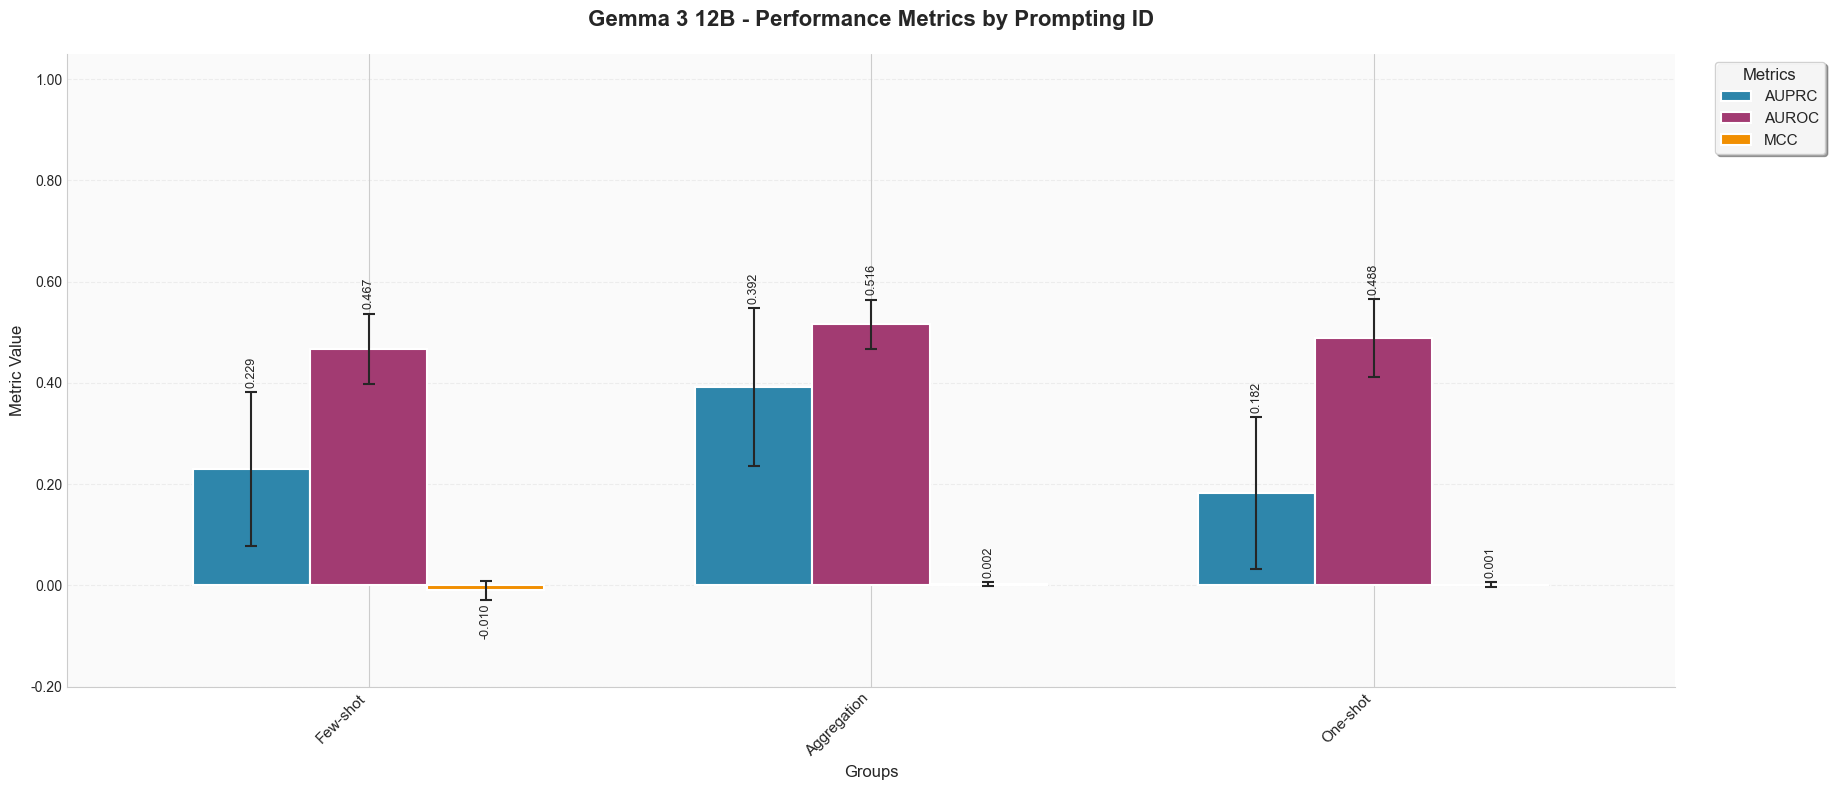

In [5]:
LLMAnalyzer.plot_metrics(
    df_results, group=["prompting_id"], title_prefix="Gemma 3 12B - ",
)

C:\Users\janbe\Documents\GitHub Repos\pulse\src\eval\llm_analyzer.py:865: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_df = plot_df.groupby(["Group", "Metric"], as_index=False).agg(


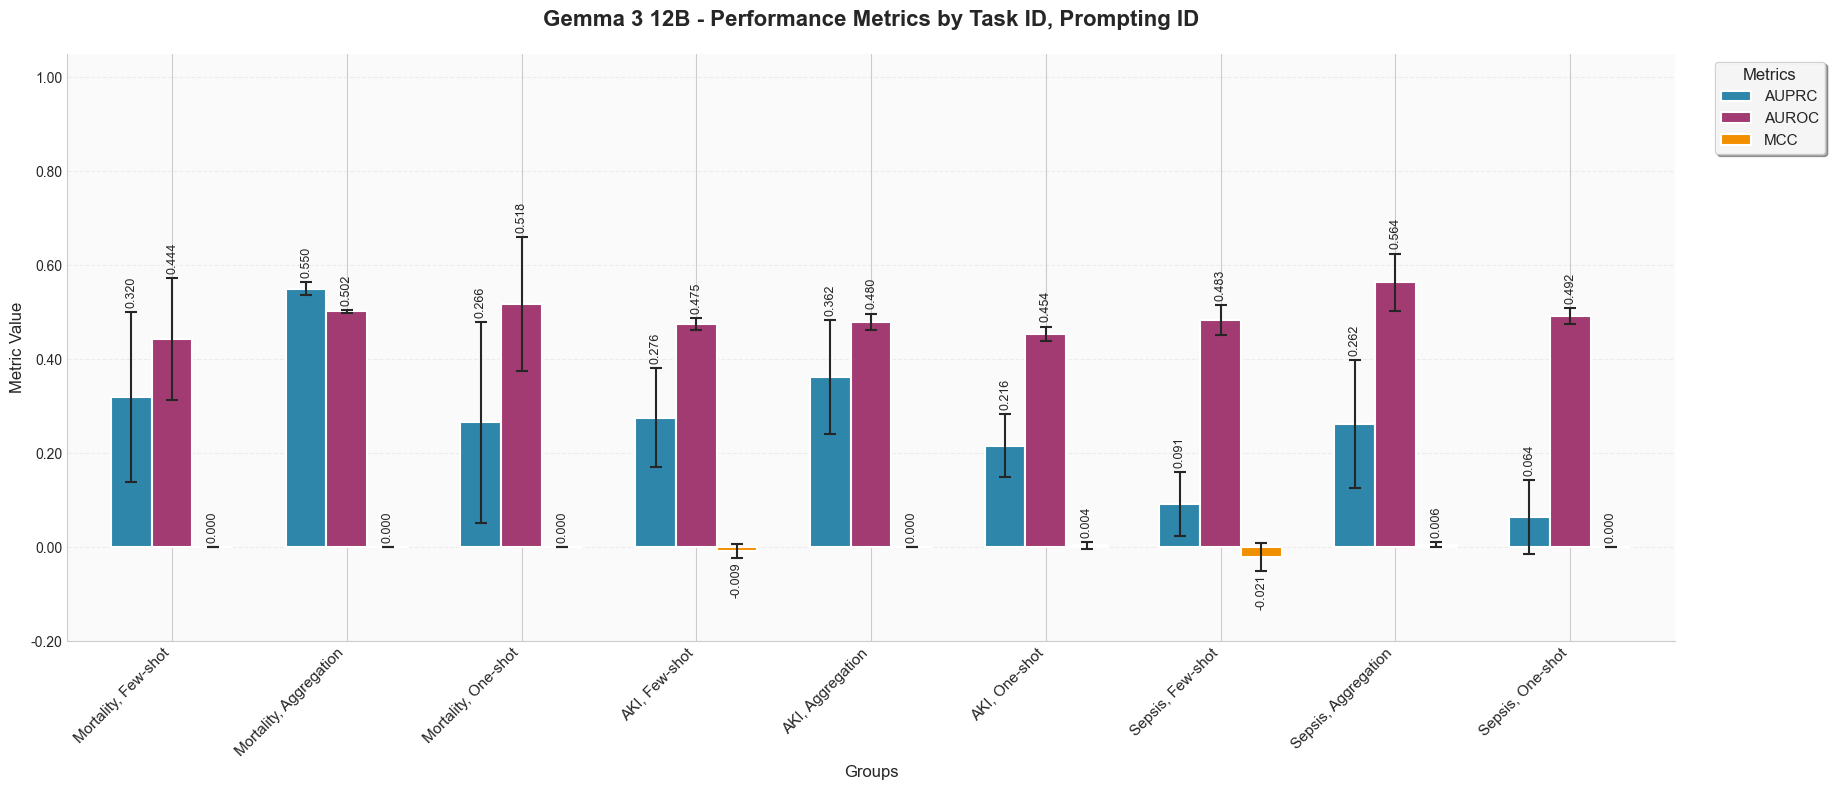

In [6]:
LLMAnalyzer.plot_metrics(
    df_results,
    group=["task_id", "prompting_id"],
    title_prefix="Gemma 3 12B - ",
)

In [7]:
import ipywidgets as widgets
from IPython.display import display

Analysis of best prompting approach

In [8]:
prompt_dropdown = widgets.Dropdown(
    options=prompt_approaches,
    value=best_prompt_approach[0],
    description='Prompt Approach:',
    style={'description_width': 'initial'}
)
display(prompt_dropdown)


Dropdown(description='Prompt Approach:', index=1, options=('liu_2023_few_shot_preprocessor', 'sarvari_2024_agg…

In [9]:
best_approach_path = os.path.join(
    base_output_dir, prompt_dropdown.value
)
print(f"Loading metadata from: {best_approach_path}")
print("======================================================")
cat_files = LLMAnalyzer.categorize_files([best_approach_path], verbose=False)
df_mdata = LLMAnalyzer.load_metadata(cat_files["metadata_files"])

Loading metadata from: C:\Users\janbe\Documents\GitHub Repos\pulse\output_to_keep\results_benchmark\llms\gemma3\sarvari_2024_aggregation_preprocessor
Model Name: Gemma3, Task: aki, Dataset: eicu, Timestamp: 20250703_100254
Model Name: Gemma3, Task: aki, Dataset: hirid, Timestamp: 20250703_100254
Model Name: Gemma3, Task: aki, Dataset: miiv, Timestamp: 20250703_100254
Model Name: Gemma3, Task: mortality, Dataset: eicu, Timestamp: 20250703_100254
Model Name: Gemma3, Task: mortality, Dataset: hirid, Timestamp: 20250703_100254
Model Name: Gemma3, Task: mortality, Dataset: miiv, Timestamp: 20250703_100254
Model Name: Gemma3, Task: sepsis, Dataset: eicu, Timestamp: 20250703_100254
Model Name: Gemma3, Task: sepsis, Dataset: hirid, Timestamp: 20250703_100254
Model Name: Gemma3, Task: sepsis, Dataset: miiv, Timestamp: 20250703_100254


In [10]:
LLMAnalyzer.print_approach_summary(df_mdata)

,task,dataset,mean_inference_time,total_inference_time,mean_input_tokens,total_input_tokens,mean_output_tokens,total_output_tokens,positive_samples,negative_samples,total_samples,pos_neg_ratio
0,aki,eicu,4.64s,4566.23s,2202,2166399,95,93534,305,679,984,0.45
1,aki,hirid,5.29s,5191.12s,2205,2165659,109,107092,159,823,982,0.19
2,aki,miiv,4.68s,4607.09s,2205,2169324,96,94766,229,755,984,0.30
3,mortality,eicu,7.68s,768.46s,2181,218065,157,15689,7,93,100,0.08
4,mortality,hirid,8.14s,813.91s,2185,218543,167,16713,11,89,100,0.12
5,mortality,miiv,7.82s,781.79s,2184,218419,160,16033,12,88,100,0.14
6,sepsis,eicu,5.93s,5808.48s,2234,2188878,122,120031,47,933,980,0.05
7,sepsis,hirid,6.90s,6684.60s,2238,2168836,143,138680,73,896,969,0.08
8,sepsis,miiv,5.67s,5613.23s,2236,2213706,117,115959,25,965,990,0.03


In [11]:
metrics_report = cat_files['metrics_report_files'][0]
df_metrics = pd.read_json(metrics_report)
df_metrics

,model_id,task_id,dataset,prompting_id,run_id,metrics_summary
0,Gemma3,mortality,eicu,sarvari_2024_aggregation_preprocessor,20250703100254,"{'overall': {'auroc': 0.5, 'auprc': 0.535, 'no..."
1,Gemma3,mortality,hirid,sarvari_2024_aggregation_preprocessor,20250703100254,"{'overall': {'auroc': 0.5, 'auprc': 0.555, 'no..."
2,Gemma3,mortality,miiv,sarvari_2024_aggregation_preprocessor,20250703100254,"{'overall': {'auroc': 0.506, 'auprc': 0.561, '..."
3,Gemma3,aki,eicu,sarvari_2024_aggregation_preprocessor,20250703100254,"{'overall': {'auroc': 0.493, 'auprc': 0.473000..."
4,Gemma3,aki,hirid,sarvari_2024_aggregation_preprocessor,20250703100254,"{'overall': {'auroc': 0.487, 'auprc': 0.233, '..."
5,Gemma3,aki,miiv,sarvari_2024_aggregation_preprocessor,20250703100254,"{'overall': {'auroc': 0.461, 'auprc': 0.381, '..."
6,Gemma3,sepsis,eicu,sarvari_2024_aggregation_preprocessor,20250703100254,"{'overall': {'auroc': 0.535, 'auprc': 0.205000..."
7,Gemma3,sepsis,hirid,sarvari_2024_aggregation_preprocessor,20250703100254,"{'overall': {'auroc': 0.634, 'auprc': 0.418, '..."
8,Gemma3,sepsis,miiv,sarvari_2024_aggregation_preprocessor,20250703100254,"{'overall': {'auroc': 0.524, 'auprc': 0.164, '..."


In [12]:
# Save metrics to results.json using the LLMAnalyzer method
added_count, updated_count = LLMAnalyzer.save_metrics_to_results_json(
    metrics_report_path=metrics_report,
    results_json_path="../docs/results.json"
)

Updating existing record: model_id='Gemma3', prompting_id='sarvari_2024_aggregation_preprocessor', task_id='mortality', dataset='eicu', run_id='20250703_100254'
Updating existing record: model_id='Gemma3', prompting_id='sarvari_2024_aggregation_preprocessor', task_id='mortality', dataset='hirid', run_id='20250703_100254'
Updating existing record: model_id='Gemma3', prompting_id='sarvari_2024_aggregation_preprocessor', task_id='mortality', dataset='miiv', run_id='20250703_100254'
Updating existing record: model_id='Gemma3', prompting_id='sarvari_2024_aggregation_preprocessor', task_id='aki', dataset='eicu', run_id='20250703_100254'
Updating existing record: model_id='Gemma3', prompting_id='sarvari_2024_aggregation_preprocessor', task_id='aki', dataset='hirid', run_id='20250703_100254'
Updating existing record: model_id='Gemma3', prompting_id='sarvari_2024_aggregation_preprocessor', task_id='aki', dataset='miiv', run_id='20250703_100254'
Updating existing record: model_id='Gemma3', promp